In [ ]:
!pip install pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 22.3 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Mon Dec  1 03:59:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   39C    P0             54W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from datetime import datetime
import time
import json
import pandas as pd

In [ ]:
import pymongo

db_username = 'username'
db_password = 'password'
URI = f'url'

client = pymongo.MongoClient(URI)

In [ ]:
db = client["project3"]
collection = db["wikipedia_holdings"]
print("Connected to MongoDB.")

Connected to MongoDB.


In [ ]:
collection

Collection(Database(MongoClient(host=['ac-x9evpbz-shard-00-02.5ibriwd.mongodb.net:27017', 'ac-x9evpbz-shard-00-00.5ibriwd.mongodb.net:27017', 'ac-x9evpbz-shard-00-01.5ibriwd.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', replicaset='atlas-8gdncg-shard-0', tls=True), 'project3'), 'wikipedia_holdings')

In [ ]:
# ===============================================================
# Step 1: Load all documents that still need embedding
# ===============================================================


todo = list(collection.find({
    "wiki_content": {"$exists": True},
    "embedding": {"$exists": False}
}))
print(f"Documents to embeddings: {len(todo)}")

Documents to embeddings: 996


In [ ]:
#DO NOT RUn again
collection.create_index([
    ('embeddings.model', pymongo.ASCENDING),
    ('embeddings.input', pymongo.ASCENDING),
    ('embeddings.chunk_size', pymongo.ASCENDING),
    ('embeddings.aggregation', pymongo.ASCENDING)
], name="embedding_config_compound_index")

'embedding_config_compound_index'

In [ ]:
embeddings_lst = ['BAAI/bge-small-en-v1.5','BAAI/bge-large-en-v1.5','sentence-transformers/all-mpnet-base-v2',
                  'nomic classification','nomic clustering','nomic search_query','nomic search_document']



### Wiki Content

In [ ]:
for model_str in embeddings_lst:
  embedding_config = {
    'model': model_str,
    'chunk_size': None,
    'aggregation': None,
    'input': 'wiki_content_only' # <-- Key for this pipeline
    }

  has_embedding_cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config } },
    { "_id": 1 }  # Only fetch the _id
  )
  # Create a set of _id's to ignore
  has_embedding_ids = {doc['_id'] for doc in has_embedding_cursor}
  print(f"Found {len(has_embedding_ids)} documents that already have this config for model: {model_str}.")

  # --- STEP 2: Find all docs *NOT IN* that set (this is your to-do list) ---
  needs_embedding_filter = {
    "_id": {"$nin": list(has_embedding_ids)}
  }
  # Fetch the documents that need processing
  # We explicitly include 'wiki_content' and '_id'
  cursor = collection.find(
    needs_embedding_filter,
    {'wiki_content': 1} # Only fetch wiki_content and _id (implicitly included)
  )

  todo_df = pd.DataFrame(list(cursor))
  print(f"Found {len(todo_df)} documents to process for model: {model_str}.")

  if todo_df.empty:
      print(f"No documents to process for model: {model_str}. Skipping.\n")
      continue

  # Doing the embedding - This part must be inside the loop
  if 'nomic' in model_str:
    # Load the one base model
    model = SentenceTransformer(
        'nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True
    )
    # Get the prefix (e.g., "classification:")
    prefix = model_str.split()[1] + ' ' # Don't forget the space!
  else:
    model = SentenceTransformer(
        model_str, trust_remote_code=True
    )

  # Chunks by 10
  num_chunks = (len(todo_df) + 9) // 10 # ceil division
  print(f"Processing {len(todo_df)} documents in {num_chunks} chunks...")

  for i in range(num_chunks):
    start_index = i * 10
    end_index = min((i + 1) * 10, len(todo_df))
    batch_df = todo_df.iloc[start_index:end_index] # Use iloc for integer-location based indexing

    contents_to_embed = batch_df['wiki_content'].tolist()
    if 'nomic' in model_str:
      contents_to_embed = [prefix + str(d) for d in contents_to_embed]

    batch_embeddings = model.encode(contents_to_embed, normalize_embeddings=True)

    # Convert embeddings to list for MongoDB storage
    embeddings_list_of_lists = batch_embeddings.tolist()

    # Prepare bulk operations for updating documents
    updates = []
    for doc_id, embedding in zip(batch_df['_id'], embeddings_list_of_lists):
        new_embedding_doc = {
            'model': embedding_config['model'],
            'chunk_size': embedding_config['chunk_size'],
            'aggregation': embedding_config['aggregation'],
            'input': embedding_config['input'],
            'embedding': embedding # Store the actual embedding vector
        }
        updates.append(
            pymongo.UpdateOne(
                {'_id': doc_id},
                {'$push': {'embeddings': new_embedding_doc}}
            )
        )
    if updates:
        collection.bulk_write(updates)
        print(f"  Updated {len(updates)} documents with embeddings for model: {model_str} in chunk {i+1}/{num_chunks}.")
  print(f"Finished processing model: {model_str}.\n")

print("All Wikipedia embedding processed.")

Found 0 documents that already have this config for model: BAAI/bge-small-en-v1.5.
Found 996 documents to process for model: BAAI/bge-small-en-v1.5.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 1/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 2/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 3/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 4/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 5/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 6/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 7/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 8/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 9/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 10/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: BAAI/bge-large-en-v1.5 in chunk 1/100.
  Updated 10 documents with embeddings for model: BAAI/bge-large-en-v1.5 in chunk 2/100.
  Updated 10 documents with embeddings for model: BAAI/bge-large-en-v1.5 in chunk 3/100.
  Updated 10 documents with embeddings for model: BAAI/bge-large-en-v1.5 in chunk 4/100.
  Updated 10 documents with embeddings for model: BAAI/bge-large-en-v1.5 in chunk 5/100.
  Updated 10 documents with embeddings for model: BAAI/bge-large-en-v1.5 in chunk 6/100.
  Updated 10 documents with embeddings for model: BAAI/bge-large-en-v1.5 in chunk 7/100.
  Updated 10 documents with embeddings for model: BAAI/bge-large-en-v1.5 in chunk 8/100.
  Updated 10 documents with embeddings for model: BAAI/bge-large-en-v1.5 in chunk 9/100.
  Updated 10 documents with embeddings for model: BAAI/bge-large-en-v1.5 in chunk 10/100.
  Updated 10 documents with embeddings for model: BAAI/bge-large-en

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: sentence-transformers/all-mpnet-base-v2 in chunk 1/100.
  Updated 10 documents with embeddings for model: sentence-transformers/all-mpnet-base-v2 in chunk 2/100.
  Updated 10 documents with embeddings for model: sentence-transformers/all-mpnet-base-v2 in chunk 3/100.
  Updated 10 documents with embeddings for model: sentence-transformers/all-mpnet-base-v2 in chunk 4/100.
  Updated 10 documents with embeddings for model: sentence-transformers/all-mpnet-base-v2 in chunk 5/100.
  Updated 10 documents with embeddings for model: sentence-transformers/all-mpnet-base-v2 in chunk 6/100.
  Updated 10 documents with embeddings for model: sentence-transformers/all-mpnet-base-v2 in chunk 7/100.
  Updated 10 documents with embeddings for model: sentence-transformers/all-mpnet-base-v2 in chunk 8/100.
  Updated 10 documents with embeddings for model: sentence-transformers/all-mpnet-base-v2 in chunk 9/100.
  Up

modules.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_hf_nomic_bert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- configuration_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hf_nomic_bert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- modeling_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: nomic classification in chunk 1/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 2/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 3/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 4/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 5/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 6/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 7/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 8/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 9/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 10/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 11/100.

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: nomic clustering in chunk 1/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 2/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 3/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 4/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 5/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 6/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 7/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 8/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 9/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 10/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 11/100.
  Updated 10 documents with embeddings for 

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: nomic search_query in chunk 1/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 2/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 3/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 4/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 5/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 6/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 7/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 8/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 9/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 10/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 11/100.
  Updated 10 document

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: nomic search_document in chunk 1/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 2/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 3/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 4/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 5/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 6/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 7/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 8/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 9/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 10/100.
  Updated 10 documents with embeddings for model: nomic search_document in ch

### Summary Only

In [ ]:
for model_str in embeddings_lst:
  embedding_config = {
    'model': model_str,
    'chunk_size': None,
    'aggregation': None,
    'input': 'SUMMARY_only' # <-- Key for this pipeline
    }

  has_embedding_cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config } },
    { "_id": 1 }  # Only fetch the _id
  )
  # Create a set of _id's to ignore
  has_embedding_ids = {doc['_id'] for doc in has_embedding_cursor}
  print(f"Found {len(has_embedding_ids)} documents that already have this config for model: {model_str}.")

  # --- STEP 2: Find all docs *NOT IN* that set (this is your to-do list) ---
  needs_embedding_filter = {
    "_id": {"$nin": list(has_embedding_ids)}
  }
  # Fetch the documents that need processing
  # We specify only the fields to include
  cursor = collection.find(
    needs_embedding_filter,
    {'SUMMARY_business_description':1, 'SUMMARY_investment_exposure':1,
    'SUMMARY_investment_industry':1, 'SUMMARY_material_points':1} # Only fetch summary fields and _id (implicitly included)
  )

  todo_df = pd.DataFrame(list(cursor))
  print(f"Found {len(todo_df)} documents to process for model: {model_str}.")

  if todo_df.empty:
      print(f"No documents to process for model: {model_str}. Skipping.\n")
      continue

  # Doing the embedding - This part must be inside the loop
  if 'nomic' in model_str:
    # Load the one base model
    model = SentenceTransformer(
        'nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True
    )
    # Get the prefix (e.g., "classification:")
    prefix = model_str.split()[1] + ' ' # Don't forget the space!
  else:
    model = SentenceTransformer(
        model_str, trust_remote_code=True
    )

  # Chunks by 10
  num_chunks = (len(todo_df) + 9) // 10 # ceil division
  print(f"Processing {len(todo_df)} documents in {num_chunks} chunks...")

  for i in range(num_chunks):
    start_index = i * 10
    end_index = min((i + 1) * 10, len(todo_df))
    batch_df =  todo_df.iloc[start_index:end_index] # Use iloc for integer-location based indexing

    summary_fields = [
    'SUMMARY_business_description', 'SUMMARY_investment_exposure',
    'SUMMARY_investment_industry', 'SUMMARY_material_points'
    ]
    contents_to_embed = [
        str(d) for d in batch_df[summary_fields].to_dict(orient='records')
    ]
    if 'nomic' in model_str:
      contents_to_embed = [prefix + str(d) for d in contents_to_embed]

    batch_embeddings = model.encode(contents_to_embed, normalize_embeddings=True)

    # Convert embeddings to list for MongoDB storage
    embeddings_list_of_lists = batch_embeddings.tolist()

    # Prepare bulk operations for updating documents
    updates = []
    for doc_id, embedding in zip(batch_df['_id'], embeddings_list_of_lists):
        new_embedding_doc = {
            'model': embedding_config['model'],
            'chunk_size': embedding_config['chunk_size'],
            'aggregation': embedding_config['aggregation'],
            'input': embedding_config['input'],
            'embedding': embedding # Store the actual embedding vector
        }
        updates.append(
            pymongo.UpdateOne(
                {'_id': doc_id},
                {'$push': {'embeddings': new_embedding_doc}}
            )
        )
    if updates:
        collection.bulk_write(updates)
        print(f"  Updated {len(updates)} documents with embeddings for model: {model_str} in chunk {i+1}/{num_chunks}.")
  print(f"Finished processing model: {model_str}.\n")

print("All SUMMARY embedding processed.")

Found 996 documents that already have this config for model: BAAI/bge-small-en-v1.5.
Found 0 documents to process for model: BAAI/bge-small-en-v1.5.
No documents to process for model: BAAI/bge-small-en-v1.5. Skipping.

Found 990 documents that already have this config for model: BAAI/bge-large-en-v1.5.
Found 6 documents to process for model: BAAI/bge-large-en-v1.5.
Processing 6 documents in 1 chunks...
  Updated 6 documents with embeddings for model: BAAI/bge-large-en-v1.5 in chunk 1/1.
Finished processing model: BAAI/bge-large-en-v1.5.

Found 0 documents that already have this config for model: sentence-transformers/all-mpnet-base-v2.
Found 996 documents to process for model: sentence-transformers/all-mpnet-base-v2.
Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: sentence-transformers/all-mpnet-base-v2 in chunk 1/100.
  Updated 10 documents with embeddings for model: sentence-transformers/all-mpnet-base-v2 in chunk 2/100.
  Updated 10 docume

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: nomic classification in chunk 1/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 2/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 3/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 4/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 5/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 6/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 7/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 8/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 9/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 10/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 11/100.

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: nomic clustering in chunk 1/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 2/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 3/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 4/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 5/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 6/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 7/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 8/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 9/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 10/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 11/100.
  Updated 10 documents with embeddings for 

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: nomic search_query in chunk 1/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 2/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 3/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 4/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 5/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 6/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 7/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 8/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 9/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 10/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 11/100.
  Updated 10 document

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: nomic search_document in chunk 1/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 2/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 3/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 4/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 5/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 6/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 7/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 8/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 9/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 10/100.
  Updated 10 documents with embeddings for model: nomic search_document in ch

### Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

In [ ]:
tmpdf = pd.DataFrame(collection.find(
    {},
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': {
                'model': 'BAAI/bge-small-en-v1.5',
                'chunk_size': None,
                'aggregation': None,
                'input': 'wiki_content_only'
            }
        }
    }))
embedding_array = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())

In [ ]:
def plot_silhouette_scores(embedding_array, labels, model_name):

    silhouette_vals = silhouette_samples(embedding_array, labels, metric='cosine')
    silhouette_avg = silhouette_score(embedding_array, labels, metric='cosine')

    fig, ax = plt.subplots(figsize=(10, 10))
    unique_labels = sorted(np.unique(labels))
    y_lower = 10

    for i, sector in enumerate(unique_labels):

        sector_mask = (labels == sector)
        sector_silhouette_vals = silhouette_vals[sector_mask]
        sector_silhouette_vals.sort()

        size = sector_silhouette_vals.shape[0]
        y_upper = y_lower + size

        color = plt.cm.nipy_spectral(float(i) / len(unique_labels))

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            sector_silhouette_vals,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )

        ax.text(-0.05, y_lower + 0.5 * size, str(sector), fontsize=8)

        y_lower = y_upper + 10

    ax.axvline(
        x=silhouette_avg,
        color="red",
        linestyle="--",
        label=f"Silhouette Average: {silhouette_avg:.3f}"
    )

    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Sector")
    ax.set_title(f"Silhouette Plot for {model_name}  (Avg Score: {silhouette_avg:.2f})")
    ax.legend()
    plt.show()

    return silhouette_avg


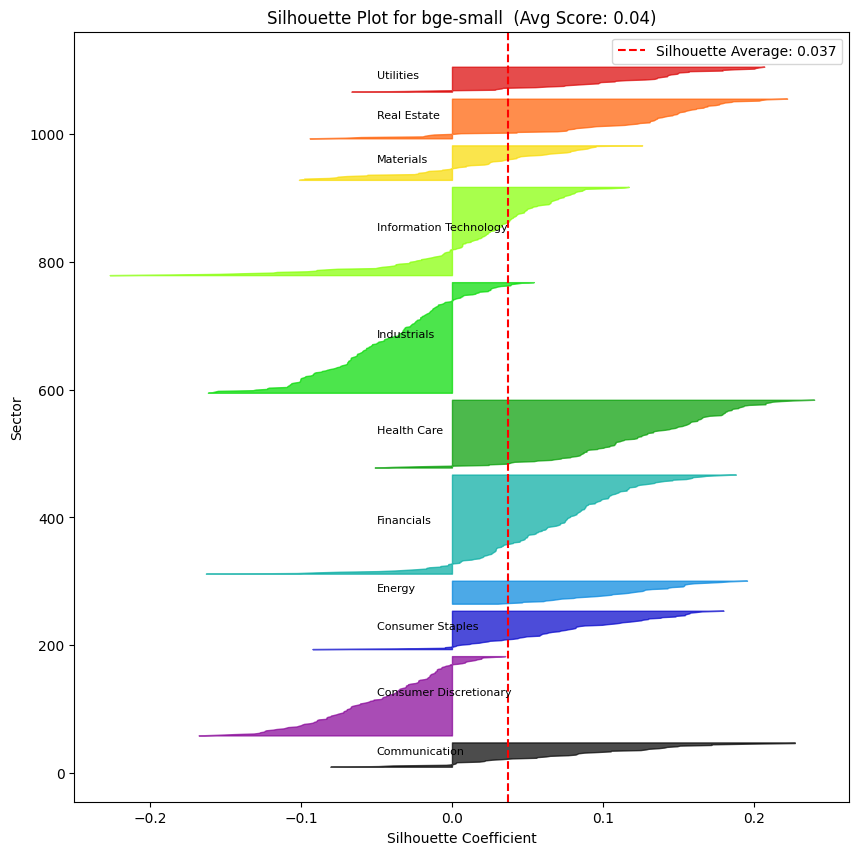

np.float64(0.036840803694588475)

In [ ]:
plot_silhouette_scores(embedding_array, tmpdf.sector, 'bge-small')

### Wiki Only

In [ ]:
wiki_content_only_silhouette = pd.Series(dtype=float)

for model_str in embeddings_lst:

    tmpdf = pd.DataFrame(collection.find(
        {},
        {
            'ticker':1,
            'sector': 1,
            'embeddings': {
                '$elemMatch': {
                    'model': model_str,
                    'chunk_size': None,
                    'aggregation': None,
                    'input': 'wiki_content_only'
                }
            }
        }
    ))

    tmpdf = tmpdf.loc[tmpdf.embeddings.notna()]

    if len(tmpdf) == 0:
        print(f"No wiki_content_only embeddings for {model_str}")
        wiki_content_only_silhouette[model_str] = np.nan
        continue

    embedding_array = np.array([emb[0]['embedding'] for emb in tmpdf.embeddings])
    labels = tmpdf['sector']

    wiki_content_only_silhouette[model_str] = silhouette_score(
        embedding_array, labels, metric='cosine'
    )

print("SILHOUETTE SCORES (WIKI CONTENT ONLY)")
display(wiki_content_only_silhouette)

SILHOUETTE SCORES (WIKI CONTENT ONLY)


,0
BAAI/bge-small-en-v1.5,0.036841
BAAI/bge-large-en-v1.5,0.037180
sentence-transformers/all-mpnet-base-v2,0.045547
nomic classification,-0.007615
nomic clustering,-0.018137
nomic search_query,-0.021351
nomic search_document,-0.019547


### Summary Only


In [ ]:
summary_only_silhouette = pd.Series(dtype=float)

for model_str in embeddings_lst:

    tmpdf = pd.DataFrame(collection.find(
        {},
        {
            'ticker':1,
            'sector': 1,
            'embeddings': {
                '$elemMatch': {
                    'model': model_str,
                    'chunk_size': None,
                    'aggregation': None,
                    'input': 'SUMMARY_only'
                }
            }
        }
    ))

    tmpdf = tmpdf.loc[tmpdf.embeddings.notna()]

    if len(tmpdf) == 0:
        print(f"No SUMMARY_only embeddings for {model_str}")
        summary_only_silhouette[model_str] = np.nan
        continue

    embedding_array = np.array([emb[0]['embedding'] for emb in tmpdf.embeddings])
    labels = tmpdf['sector']

    summary_only_silhouette[model_str] = silhouette_score(embedding_array, labels, metric='cosine')

print("SILHOUETTE SCORES (SUMMARY ONLY)")
display(summary_only_silhouette)


SILHOUETTE SCORES (SUMMARY ONLY)


,0
BAAI/bge-small-en-v1.5,0.041492
BAAI/bge-large-en-v1.5,0.045772
sentence-transformers/all-mpnet-base-v2,0.045070
nomic classification,0.077546
nomic clustering,0.068625
nomic search_query,0.054863
nomic search_document,0.047128


### Comparison

In [ ]:
comparison_df = pd.DataFrame({
    "model": embeddings_lst,
    "wiki_content_silhouette": wiki_content_only_silhouette.values,
    "summary_silhouette": summary_only_silhouette.values
})

print("FINAL COMPARISON: WIKI vs SUMMARY SILHOUETTE SCORES")
display(comparison_df)


FINAL COMPARISON: WIKI vs SUMMARY SILHOUETTE SCORES


,model,wiki_content_silhouette,summary_silhouette
0,BAAI/bge-small-en-v1.5,0.036841,0.041428
1,BAAI/bge-large-en-v1.5,0.037180,0.051380
2,sentence-transformers/all-mpnet-base-v2,0.045547,0.049855
3,nomic classification,-0.007615,0.081591
4,nomic clustering,-0.018137,0.069737
5,nomic search_query,-0.021351,0.057699
6,nomic search_document,-0.019547,0.048393


### Better

In [ ]:
comparison_df["better_text_source"] = np.where(
    comparison_df["wiki_content_silhouette"] > comparison_df["summary_silhouette"],
    "wiki_content",
    "summary"
)

print("WHICH TEXT IS BETTER FOR EACH MODEL?")
display(comparison_df[["model", "better_text_source"]])

WHICH TEXT IS BETTER FOR EACH MODEL?


,model,better_text_source
0,BAAI/bge-small-en-v1.5,summary
1,BAAI/bge-large-en-v1.5,summary
2,sentence-transformers/all-mpnet-base-v2,wiki_content
3,nomic classification,summary
4,nomic clustering,summary
5,nomic search_query,summary
6,nomic search_document,summary


### Chunking and Aggregation Test

In [ ]:
chunks = ['250', '500', '1000']
aggregations = ['first','mean','exponential']

In [ ]:
for chunk_size in chunks:
    chunk_size = int(chunk_size)
    for agg in aggregations:
      for model_str in embeddings_lst:

          # Build embedding_config for this run
          embedding_config = {
              'model': model_str,
              'chunk_size': chunk_size,
              'aggregation': agg,
              'input': 'wiki_content_only'
          }

          # Find docs ALREADY processed (avoid duplicates)
          has_embedding_cursor = collection.find(
              {'embeddings': {'$elemMatch': embedding_config}},
              {'_id': 1}
          )
          existing_ids = {doc['_id'] for doc in has_embedding_cursor}

          print(f"[INFO] {len(existing_ids)} docs already processed "
                f"→ model={model_str}, chunk={chunk_size}, agg={agg}")

          # Find docs still needing embeddings
          cursor = collection.find(
              {'_id': {'$nin': list(existing_ids)}},
              {'wiki_content': 1}
          )
          todo_df = pd.DataFrame(list(cursor))

          print(f"[INFO] {len(todo_df)} docs remaining "
                f"→ model={model_str}, chunk={chunk_size}, agg={agg}")

          if todo_df.empty:
              continue

          # Load model
          if 'nomic' in model_str:
              base_model = SentenceTransformer(
                  "nomic-ai/nomic-embed-text-v1.5",
                  trust_remote_code=True
              )
              prefix = model_str.split()[1] + " "
          else:
              base_model = SentenceTransformer(
                  model_str,
                  trust_remote_code=True
              )
              prefix = ""

          # Process documents in batches of 10
          num_batches = (len(todo_df) + 9) // 10

          for b in range(num_batches):
              start = b * 10
              end = min((b + 1) * 10, len(todo_df))
              batch_df = todo_df.iloc[start:end]

              # List to store (doc_id, embedding) pairs for current batch
              embeddings_to_update_in_batch = []

              # Chunk EACH DOCUMENT individually
              for idx, row in batch_df.iterrows():
                  doc_id = row['_id']
                  doc_text = row['wiki_content']

                  # Ensure we handle non-string values safely
                  if not isinstance(doc_text, str):
                      doc_text = str(doc_text)

                  # Split into chunks of LENGTH chunk_size (characters)
                  text_chunks = [
                      doc_text[i:i + chunk_size]
                      for i in range(0, len(doc_text), chunk_size)
                  ]

                  # If no chunks are generated (e.g., empty doc_text or too short), skip this document
                  if not text_chunks:
                      print(f"[WARNING] Skipping document {doc_id} (empty/short 'wiki_content') for model={model_str}, chunk={chunk_size}, agg={agg} in batch {b+1}/{num_batches}")
                      continue

                  # Add prefix for NOMIC
                  processed_text_chunks = [prefix + t for t in text_chunks]

                  # Encode each chunk
                  chunk_embs = base_model.encode(
                      processed_text_chunks,
                      normalize_embeddings=True,
                      batch_size=8 # Added to limit GPU memory usage per encoding call
                  )
                  chunk_embs = np.array(chunk_embs)

                  # Apply aggregation rule
                  final_emb = None
                  if agg == "first":
                      final_emb = chunk_embs[0]

                  elif agg == "mean":
                      final_emb = chunk_embs.mean(axis=0)

                  elif agg == "exponential":
                      weights = np.exp(-np.arange(len(chunk_embs)) / 2)
                      final_emb = np.average(chunk_embs, axis=0, weights=weights)

                  # Store the successfully generated embedding with its document ID
                  if final_emb is not None:
                      embeddings_to_update_in_batch.append((doc_id, final_emb.tolist()))

              # Prepare bulk operations for updating documents that had embeddings generated in this batch
              updates = []
              for doc_id, emb_list in embeddings_to_update_in_batch:
                  new_embedding_doc = {
                      'model': model_str,
                      'chunk_size': chunk_size,
                      'aggregation': agg,
                      'input': 'wiki_content_only',
                      'embedding': emb_list
                  }

                  updates.append(
                      pymongo.UpdateOne(
                          {'_id': doc_id},
                          {'$push': {'embeddings': new_embedding_doc}}
                      )
                  )

              if updates:
                  collection.bulk_write(updates)
                  print(f"  [OK] Updated {len(updates)} docs "
                        f"model={model_str}, chunk={chunk_size}, agg={agg} in batch {b+1}/{num_batches}.")
              else:
                  print(f"  [INFO] No documents updated for model={model_str}, chunk={chunk_size}, agg={agg} in batch {b+1}/{num_batches} (all docs in batch skipped).")

      print(f"Completed chunk_size={chunk_size}, agg={agg}")

print("ALL CHUNKED WIKIPEDIA EMBEDDINGS COMPLETED")

[INFO] 0 docs already processed → model=BAAI/bge-small-en-v1.5, chunk=250, agg=first
[INFO] 996 docs remaining → model=BAAI/bge-small-en-v1.5, chunk=250, agg=first
  [OK] Updated 10 docs model=BAAI/bge-small-en-v1.5, chunk=250, agg=first in batch 1/100.
  [OK] Updated 10 docs model=BAAI/bge-small-en-v1.5, chunk=250, agg=first in batch 2/100.
[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=BAAI/bge-small-en-v1.5, chunk=250, agg=first in batch 3/100
  [OK] Updated 9 docs model=BAAI/bge-small-en-v1.5, chunk=250, agg=first in batch 3/100.
  [OK] Updated 10 docs model=BAAI/bge-small-en-v1.5, chunk=250, agg=first in batch 4/100.
  [OK] Updated 10 docs model=BAAI/bge-small-en-v1.5, chunk=250, agg=first in batch 5/100.
  [OK] Updated 10 docs model=BAAI/bge-small-en-v1.5, chunk=250, agg=first in batch 6/100.
  [OK] Updated 10 docs model=BAAI/bge-small-en-v1.5, chunk=250, agg=first in batch 7/100.
  [OK] Updated 10 docs model=BAAI/bge-small-en-v1.5, ch

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=first in batch 1/1
  [INFO] No documents updated for model=nomic classification, chunk=250, agg=first in batch 1/1 (all docs in bat

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=first in batch 1/1
  [INFO] No documents updated for model=nomic clustering, chunk=250, agg=first in batch 1/1 (all docs in batch skipped).
[INFO] 990 docs

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=first in batch 1/1
  [INFO] No documents updated for model=nomic search_query, chunk=250, agg=first in batch 1/1 (all docs in batch skipped).
[

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=first in batch 1/1
  [INFO] No documents updated for model=nomic search_document, chunk=250, agg=first in batch 1/1 (all docs

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=mean in batch 1/1
  [INFO] No documents updated for model=nomic classification, chunk=250, agg=mean in batch 1/1 (all docs in batch skip

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=mean in batch 1/1
  [INFO] No documents updated for model=nomic clustering, chunk=250, agg=mean in batch 1/1 (all docs in batch skipped).
[INFO] 990 docs alread

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=mean in batch 1/1
  [INFO] No documents updated for model=nomic search_query, chunk=250, agg=mean in batch 1/1 (all docs in batch skipped).
[INFO] 9

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=mean in batch 1/1
  [INFO] No documents updated for model=nomic search_document, chunk=250, agg=mean in batch 1/1 (all docs in bat

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic classification, chunk=250, agg=exponential in batch 1/1
  [INFO] No documents updated for model=nomic classification, chunk=250, agg

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic clustering, chunk=250, agg=exponential in batch 1/1
  [INFO] No documents updated for model=nomic clustering, chunk=250, agg=exponential in batch 1/1 (a

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_query, chunk=250, agg=exponential in batch 1/1
  [INFO] No documents updated for model=nomic search_query, chunk=250, agg=exponential i

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_document, chunk=250, agg=exponential in batch 1/1
  [INFO] No documents updated for model=nomic search_document, chunk=2

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=first in batch 1/1
  [INFO] No documents updated for model=nomic classification, chunk=500, agg=first in batch 1/1 (all docs in bat

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=first in batch 1/1
  [INFO] No documents updated for model=nomic clustering, chunk=500, agg=first in batch 1/1 (all docs in batch skipped).
[INFO] 990 docs

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=first in batch 1/1
  [INFO] No documents updated for model=nomic search_query, chunk=500, agg=first in batch 1/1 (all docs in batch skipped).
[

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=first in batch 1/1
  [INFO] No documents updated for model=nomic search_document, chunk=500, agg=first in batch 1/1 (all docs

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=mean in batch 1/1
  [INFO] No documents updated for model=nomic classification, chunk=500, agg=mean in batch 1/1 (all docs in batch skip

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=mean in batch 1/1
  [INFO] No documents updated for model=nomic clustering, chunk=500, agg=mean in batch 1/1 (all docs in batch skipped).
[INFO] 990 docs alread

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=mean in batch 1/1
  [INFO] No documents updated for model=nomic search_query, chunk=500, agg=mean in batch 1/1 (all docs in batch skipped).
[INFO] 9

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=mean in batch 1/1
  [INFO] No documents updated for model=nomic search_document, chunk=500, agg=mean in batch 1/1 (all docs in bat

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic classification, chunk=500, agg=exponential in batch 1/1
  [INFO] No documents updated for model=nomic classification, chunk=500, agg

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic clustering, chunk=500, agg=exponential in batch 1/1
  [INFO] No documents updated for model=nomic clustering, chunk=500, agg=exponential in batch 1/1 (a

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_query, chunk=500, agg=exponential in batch 1/1
  [INFO] No documents updated for model=nomic search_query, chunk=500, agg=exponential i

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_document, chunk=500, agg=exponential in batch 1/1
  [INFO] No documents updated for model=nomic search_document, chunk=5

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=first in batch 1/1
  [INFO] No documents updated for model=nomic classification, chunk=1000, agg=first in batch 1/1 (all docs

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=first in batch 1/1
  [INFO] No documents updated for model=nomic clustering, chunk=1000, agg=first in batch 1/1 (all docs in batch skipped).
[INFO] 9

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=first in batch 1/1
  [INFO] No documents updated for model=nomic search_query, chunk=1000, agg=first in batch 1/1 (all docs in batch skip

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=first in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=first in batch 1/1
  [INFO] No documents updated for model=nomic search_document, chunk=1000, agg=first in batch 1/1 (a

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=mean in batch 1/1
  [INFO] No documents updated for model=nomic classification, chunk=1000, agg=mean in batch 1/1 (all docs in bat

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=mean in batch 1/1
  [INFO] No documents updated for model=nomic clustering, chunk=1000, agg=mean in batch 1/1 (all docs in batch skipped).
[INFO] 990 docs

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=mean in batch 1/1
  [INFO] No documents updated for model=nomic search_query, chunk=1000, agg=mean in batch 1/1 (all docs in batch skipped).
[

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=mean in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=mean in batch 1/1
  [INFO] No documents updated for model=nomic search_document, chunk=1000, agg=mean in batch 1/1 (all docs

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic classification, chunk=1000, agg=exponential in batch 1/1
  [INFO] No documents updated for model=nomic classification, chunk=10

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic clustering, chunk=1000, agg=exponential in batch 1/1
  [INFO] No documents updated for model=nomic clustering, chunk=1000, agg=exponential in batch

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_query, chunk=1000, agg=exponential in batch 1/1
  [INFO] No documents updated for model=nomic search_query, chunk=1000, agg=expone

[WARNING] Skipping document 690c2f0530de78ca9390a990 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ab30 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390acf9 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad58 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad62 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=exponential in batch 1/1
[WARNING] Skipping document 690c2f0530de78ca9390ad69 (empty/short 'wiki_content') for model=nomic search_document, chunk=1000, agg=exponential in batch 1/1
  [INFO] No documents updated for model=nomic search_document, c

#### Silhouette Scores

##### 250

In [ ]:
wiki_content_250_first_silhouette = pd.Series(dtype=float)

for model_str in embeddings_lst:
  embedding_config_for_query = {
      'model': model_str,
      'chunk_size': 250,
      'aggregation': 'first',
      'input': 'wiki_content_only'
  }

  # Filter directly in MongoDB to only get documents that have the matching embedding
  cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config_for_query } },
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': embedding_config_for_query
        }
    })

  tmpdf = pd.DataFrame(list(cursor))

  if tmpdf.empty:
      print(f"No documents found with embeddings matching config for model: {model_str}, chunk_size: 250, aggregation: first. Skipping.")
      wiki_content_250_first_silhouette[model_str] = np.nan
      continue

  # At this point, tmpdf is guaranteed to have an 'embeddings' column with non-empty lists
  embedding_array = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  labels = tmpdf.sector # Get labels directly from tmpdf
  wiki_content_250_first_silhouette[model_str] = silhouette_score(embedding_array, labels, metric='cosine')

print("SILHOUETTE SCORES (WIKI CONTENT ONLY, 250 FIRST)")
display(wiki_content_250_first_silhouette)

SILHOUETTE SCORES (WIKI CONTENT ONLY, 250 FIRST)


,0
BAAI/bge-small-en-v1.5,0.034055
BAAI/bge-large-en-v1.5,0.029494
sentence-transformers/all-mpnet-base-v2,0.026920
nomic classification,0.048073
nomic clustering,0.044128
nomic search_query,0.035485
nomic search_document,0.028377


In [ ]:
wiki_content_250_mean_silhouette = pd.Series(dtype=float)
for model_str in embeddings_lst:
  embedding_config_for_query = {
      'model': model_str,
      'chunk_size': 250,
      'aggregation': 'mean',
      'input': 'wiki_content_only'
  }

  # Filter directly in MongoDB to only get documents that have the matching embedding
  cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config_for_query } },
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': embedding_config_for_query
        }
    })

  tmpdf = pd.DataFrame(list(cursor))

  if tmpdf.empty:
      print(f"No documents found with embeddings matching config for model: {model_str}, chunk_size: 250, aggregation: mean. Skipping.")
      wiki_content_250_mean_silhouette[model_str] = np.nan
      continue
  embedding_array = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  labels = tmpdf.sector # Get labels directly from tmpdf
  wiki_content_250_mean_silhouette[model_str] = silhouette_score(embedding_array, labels, metric='cosine')

print("SILHOUETTE SCORES (WIKI CONTENT ONLY, 250 MEAN)")
display(wiki_content_250_mean_silhouette)

SILHOUETTE SCORES (WIKI CONTENT ONLY, 250 MEAN)


,0
BAAI/bge-small-en-v1.5,0.058719
BAAI/bge-large-en-v1.5,0.057649
sentence-transformers/all-mpnet-base-v2,0.061963
nomic classification,0.066378
nomic clustering,0.065715
nomic search_query,0.048922
nomic search_document,0.042925


In [ ]:
wiki_content_250_exp_silhouette = pd.Series(dtype=float)
for model_str in embeddings_lst:
  embedding_config_for_query = {
      'model': model_str,
      'chunk_size': 250,
      'aggregation': 'exponential',
      'input': 'wiki_content_only'
  }

  # Filter directly in MongoDB to only get documents that have the matching embedding
  cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config_for_query } },
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': embedding_config_for_query
        }
    })

  tmpdf = pd.DataFrame(list(cursor))

  if tmpdf.empty:
      print(f"No documents found with embeddings matching config for model: {model_str}, chunk_size: 250, aggregation: exponential. Skipping.")
      wiki_content_250_exp_silhouette[model_str] = np.nan
      continue
  embedding_array = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  labels = tmpdf.sector # Get labels directly from tmpdf
  wiki_content_250_exp_silhouette[model_str] = silhouette_score(embedding_array, labels, metric='cosine')

print("SILHOUETTE SCORES (WIKI CONTENT ONLY, 250 EXPONENTIAL)")
display(wiki_content_250_exp_silhouette)

SILHOUETTE SCORES (WIKI CONTENT ONLY, 250 EXPONENTIAL)


,0
BAAI/bge-small-en-v1.5,0.047362
BAAI/bge-large-en-v1.5,0.051567
sentence-transformers/all-mpnet-base-v2,0.046467
nomic classification,0.060881
nomic clustering,0.054726
nomic search_query,0.045343
nomic search_document,0.042090


##### 500

In [ ]:
wiki_content_500_first_silhouette = pd.Series(dtype=float)
for model_str in embeddings_lst:
  embedding_config_for_query = {
      'model': model_str,
      'chunk_size': 500,
      'aggregation': 'first',
      'input': 'wiki_content_only'
  }

  # Filter directly in MongoDB to only get documents that have the matching embedding
  cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config_for_query } },
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': embedding_config_for_query
        }
    })

  tmpdf = pd.DataFrame(list(cursor))

  if tmpdf.empty:
      print(f"No documents found with embeddings matching config for model: {model_str}, chunk_size: 500, aggregation: first. Skipping.")
      wiki_content_500_first_silhouette[model_str] = np.nan
      continue

  embedding_array = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  labels = tmpdf.sector
  wiki_content_500_first_silhouette[model_str] = silhouette_score(embedding_array, labels, metric='cosine')

print("SILHOUETTE SCORES (WIKI CONTENT ONLY, 500 FIRST)")
display(wiki_content_500_first_silhouette)

SILHOUETTE SCORES (WIKI CONTENT ONLY, 500 FIRST)


,0
BAAI/bge-small-en-v1.5,0.036323
BAAI/bge-large-en-v1.5,0.031072
sentence-transformers/all-mpnet-base-v2,0.034081
nomic classification,0.051212
nomic clustering,0.045938
nomic search_query,0.037133
nomic search_document,0.031377


In [ ]:
wiki_content_500_mean_silhouette = pd.Series(dtype=float)
for model_str in embeddings_lst:
  embedding_config_for_query = {
      'model': model_str,
      'chunk_size': 500,
      'aggregation': 'mean',
      'input': 'wiki_content_only'
  }

  # Filter directly in MongoDB to only get documents that have the matching embedding
  cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config_for_query } },
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': embedding_config_for_query
        }
    })

  tmpdf = pd.DataFrame(list(cursor))

  if tmpdf.empty:
      print(f"No documents found with embeddings matching config for model: {model_str}, chunk_size: 500, aggregation: mean. Skipping.")
      wiki_content_500_mean_silhouette[model_str] = np.nan
      continue
  embedding_array = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  labels = tmpdf.sector
  wiki_content_500_mean_silhouette[model_str] = silhouette_score(embedding_array, labels, metric='cosine')

print("SILHOUETTE SCORES (WIKI CONTENT ONLY, 500 MEAN)")
display(wiki_content_500_mean_silhouette)

SILHOUETTE SCORES (WIKI CONTENT ONLY, 500 MEAN)


,0
BAAI/bge-small-en-v1.5,0.050579
BAAI/bge-large-en-v1.5,0.045375
sentence-transformers/all-mpnet-base-v2,0.055709
nomic classification,0.060139
nomic clustering,0.058488
nomic search_query,0.041800
nomic search_document,0.035415


In [ ]:
wiki_content_500_exp_silhouette = pd.Series(dtype=float)
for model_str in embeddings_lst:
  embedding_config_for_query = {
      'model': model_str,
      'chunk_size': 500,
      'aggregation': 'exponential',
      'input': 'wiki_content_only'
  }

  # Filter directly in MongoDB to only get documents that have the matching embedding
  cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config_for_query } },
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': embedding_config_for_query
        }
    })

  tmpdf = pd.DataFrame(list(cursor))

  if tmpdf.empty:
      print(f"No documents found with embeddings matching config for model: {model_str}, chunk_size: 500, aggregation: exponential. Skipping.")
      wiki_content_500_exp_silhouette[model_str] = np.nan
      continue

  embedding_array = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  labels = tmpdf.sector
  wiki_content_500_exp_silhouette[model_str] = silhouette_score(embedding_array, labels, metric='cosine')

print("SILHOUETTE SCORES (WIKI CONTENT ONLY, 500 EXPONENTIAL)")
display(wiki_content_500_exp_silhouette)

SILHOUETTE SCORES (WIKI CONTENT ONLY, 500 EXPONENTIAL)


,0
BAAI/bge-small-en-v1.5,0.050550
BAAI/bge-large-en-v1.5,0.050144
sentence-transformers/all-mpnet-base-v2,0.046303
nomic classification,0.059528
nomic clustering,0.053448
nomic search_query,0.043428
nomic search_document,0.040955


##### 1000

In [ ]:
wiki_content_1000_first_silhouette = pd.Series(dtype=float)
for model_str in embeddings_lst:
  embedding_config_for_query = {
    'model': model_str,
    'chunk_size': 1000,
    'aggregation': 'first',
    'input': 'wiki_content_only'
  }

  # Filter directly in MongoDB to only get documents that have the matching embedding
  cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config_for_query } },
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': embedding_config_for_query
        }
    })

  tmpdf = pd.DataFrame(list(cursor))

  if tmpdf.empty:
      print(f"No documents found with embeddings matching config for model: {model_str}, chunk_size: 1000, aggregation: first. Skipping.")
      wiki_content_1000_first_silhouette[model_str] = np.nan
      continue
  embedding_array = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  labels = tmpdf.sector
  wiki_content_1000_first_silhouette[model_str] = silhouette_score(embedding_array, labels, metric='cosine')

print("SILHOUETTE SCORES (WIKI CONTENT ONLY, 1000 FIRST)")
display(wiki_content_1000_first_silhouette)

SILHOUETTE SCORES (WIKI CONTENT ONLY, 1000 FIRST)


,0
BAAI/bge-small-en-v1.5,0.036394
BAAI/bge-large-en-v1.5,0.033023
sentence-transformers/all-mpnet-base-v2,0.042382
nomic classification,0.051027
nomic clustering,0.047140
nomic search_query,0.035564
nomic search_document,0.030649


In [ ]:
wiki_content_1000_mean_silhouette = pd.Series(dtype=float)
for model_str in embeddings_lst:
  embedding_config_for_query = {
    'model': model_str,
    'chunk_size': 1000,
    'aggregation': 'mean',
    'input': 'wiki_content_only'
  }

  # Filter directly in MongoDB to only get documents that have the matching embedding
  cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config_for_query } },
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': embedding_config_for_query
        }
    })

  tmpdf = pd.DataFrame(list(cursor))

  if tmpdf.empty:
      print(f"No documents found with embeddings matching config for model: {model_str}, chunk_size: 1000, aggregation: mean. Skipping.")
      wiki_content_1000_mean_silhouette[model_str] = np.nan
      continue
  embedding_array = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  labels = tmpdf.sector
  wiki_content_1000_mean_silhouette[model_str] = silhouette_score(embedding_array, labels, metric='cosine')

print("SILHOUETTE SCORES (WIKI CONTENT ONLY, 1000 MEAN)")
display(wiki_content_1000_mean_silhouette)

SILHOUETTE SCORES (WIKI CONTENT ONLY, 1000 MEAN)


,0
BAAI/bge-small-en-v1.5,0.040809
BAAI/bge-large-en-v1.5,0.027927
sentence-transformers/all-mpnet-base-v2,0.054709
nomic classification,0.056935
nomic clustering,0.055569
nomic search_query,0.036247
nomic search_document,0.028563


In [ ]:
wiki_content_1000_exp_silhouette = pd.Series(dtype=float)
for model_str in embeddings_lst:
  embedding_config_for_query = {
    'model': model_str,
    'chunk_size': 1000,
    'aggregation': 'exponential',
    'input': 'wiki_content_only'
  }

  # Filter directly in MongoDB to only get documents that have the matching embedding
  cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config_for_query } },
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': embedding_config_for_query
        }
    })

  tmpdf = pd.DataFrame(list(cursor))

  if tmpdf.empty:
      print(f"No documents found with embeddings matching config for model: {model_str}, chunk_size: 1000, aggregation: exponential. Skipping.")
      wiki_content_1000_exp_silhouette[model_str] = np.nan
      continue
  embedding_array = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  labels = tmpdf.sector
  wiki_content_1000_exp_silhouette[model_str] = silhouette_score(embedding_array, labels, metric='cosine')

print("SILHOUETTE SCORES (WIKI CONTENT ONLY, 1000 EXPONENTIAL)")
display(wiki_content_1000_exp_silhouette)

SILHOUETTE SCORES (WIKI CONTENT ONLY, 1000 EXPONENTIAL)


,0
BAAI/bge-small-en-v1.5,0.050731
BAAI/bge-large-en-v1.5,0.041710
sentence-transformers/all-mpnet-base-v2,0.050200
nomic classification,0.057298
nomic clustering,0.053967
nomic search_query,0.039956
nomic search_document,0.036258


### Summary and V-Card

In [ ]:
for model_str in embeddings_lst:
  embedding_config = {
    'model': model_str,
    'chunk_size': None,
    'aggregation': None,
    'input': 'SUMMARY_andEXTRA' # <-- Key for this pipeline
    }

  has_embedding_cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config } },
    { "_id": 1 }  # Only fetch the _id
  )
  # Create a set of _id's to ignore
  has_embedding_ids = {doc['_id'] for doc in has_embedding_cursor}
  print(f"Found {len(has_embedding_ids)} documents that already have this config for model: {model_str}.")

  # --- STEP 2: Find all docs *NOT IN* that set (this is your to-do list) ---
  needs_embedding_filter = {
    "_id": {"$nin": list(has_embedding_ids)}
  }
  # Fetch the documents that need processing
  # We exclude 'embeddings' from the projection to save memory
  cursor = collection.find(
    needs_embedding_filter,
    { 'SUMMARY_business_description':1, 'SUMMARY_investment_exposure':1,
    'SUMMARY_investment_industry':1, 'SUMMARY_material_points':1,'wiki_vcard':1} # Only fetch summary and _id
  )

  todo_df = pd.DataFrame(list(cursor))
  print(f"Found {len(todo_df)} documents to process for model: {model_str}.")

  if todo_df.empty:
      print(f"No documents to process for model: {model_str}. Skipping.\n")
      continue

  # Doing the embedding - This part must be inside the loop
  if 'nomic' in model_str:
    # Load the one base model
    model = SentenceTransformer(
        'nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True
    )
    # Get the prefix (e.g., "classification:")
    prefix = model_str.split()[1] + ' ' # Don't forget the space!
  else:
    model = SentenceTransformer(
        model_str, trust_remote_code=True
    )

  # Chunks by 10
  num_chunks = (len(todo_df) + 9) // 10 # ceil division
  print(f"Processing {len(todo_df)} documents in {num_chunks} chunks...")

  for i in range(num_chunks):
    start_index = i * 10
    end_index = min((i + 1) * 10, len(todo_df))
    batch_df =  todo_df.iloc[start_index:end_index] # Use iloc for integer-location based indexing

    summary_fields = [
    'SUMMARY_business_description', 'SUMMARY_investment_exposure',
    'SUMMARY_investment_industry', 'SUMMARY_material_points','wiki_vcard'
    ]
    contents_to_embed = [
        str(d) for d in batch_df[summary_fields].to_dict(orient='records')
    ]
    if 'nomic' in model_str:
      contents_to_embed = [prefix + str(d) for d in contents_to_embed]

    batch_embeddings = model.encode(contents_to_embed, normalize_embeddings=True)

    # Convert embeddings to list for MongoDB storage
    embeddings_list_of_lists = batch_embeddings.tolist()

    # Prepare bulk operations for updating documents
    updates = []
    for doc_id, embedding in zip(batch_df['_id'], embeddings_list_of_lists):
        new_embedding_doc = {
            'model': embedding_config['model'],
            'chunk_size': embedding_config['chunk_size'],
            'aggregation': embedding_config['aggregation'],
            'input': embedding_config['input'],
            'embedding': embedding # Store the actual embedding vector
        }
        updates.append(
            pymongo.UpdateOne(
                {'_id': doc_id},
                {'$push': {'embeddings': new_embedding_doc}}
            )
        )
    if updates:
        collection.bulk_write(updates)
        print(f"  Updated {len(updates)} documents with embeddings for model: {model_str} in chunk {i+1}/{num_chunks}.")
  print(f"Finished processing model: {model_str}.\n")

print("All SUMMARY embedding processed.")

Found 0 documents that already have this config for model: BAAI/bge-small-en-v1.5.
Found 996 documents to process for model: BAAI/bge-small-en-v1.5.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 1/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 2/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 3/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 4/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 5/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 6/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 7/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 8/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 9/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en-v1.5 in chunk 10/100.
  Updated 10 documents with embeddings for model: BAAI/bge-small-en

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: nomic classification in chunk 1/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 2/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 3/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 4/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 5/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 6/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 7/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 8/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 9/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 10/100.
  Updated 10 documents with embeddings for model: nomic classification in chunk 11/100.

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: nomic clustering in chunk 1/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 2/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 3/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 4/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 5/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 6/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 7/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 8/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 9/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 10/100.
  Updated 10 documents with embeddings for model: nomic clustering in chunk 11/100.
  Updated 10 documents with embeddings for 

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: nomic search_query in chunk 1/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 2/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 3/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 4/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 5/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 6/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 7/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 8/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 9/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 10/100.
  Updated 10 documents with embeddings for model: nomic search_query in chunk 11/100.
  Updated 10 document

Processing 996 documents in 100 chunks...
  Updated 10 documents with embeddings for model: nomic search_document in chunk 1/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 2/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 3/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 4/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 5/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 6/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 7/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 8/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 9/100.
  Updated 10 documents with embeddings for model: nomic search_document in chunk 10/100.
  Updated 10 documents with embeddings for model: nomic search_document in ch

In [ ]:
summary_plus_silhouette = pd.Series(dtype=float)

for model_str in embeddings_lst:

    tmpdf = pd.DataFrame(collection.find(
        {},
        {
            'ticker':1,
            'sector': 1,
            'embeddings': {
                '$elemMatch': {
                    'model': model_str,
                    'chunk_size': None,
                    'aggregation': None,
                    'input': 'SUMMARY_andEXTRA'
                }
            }
        }
    ))

    tmpdf = tmpdf.loc[tmpdf.embeddings.notna()]

    if len(tmpdf) == 0:
        print(f"No SUMMARY_andEXTRA embeddings for {model_str}")
        summary_plus_silhouette[model_str] = np.nan
        continue

    embedding_array = np.array([emb[0]['embedding'] for emb in tmpdf.embeddings])
    labels = tmpdf['sector']

    summary_plus_silhouette[model_str] = silhouette_score(embedding_array, labels, metric='cosine')

print("SILHOUETTE SCORES (SUMMARY AND VCARD)")
display(summary_plus_silhouette)

SILHOUETTE SCORES (SUMMARY AND VCARD)


,0
BAAI/bge-small-en-v1.5,0.041428
BAAI/bge-large-en-v1.5,0.051380
sentence-transformers/all-mpnet-base-v2,0.049855
nomic classification,0.081591
nomic clustering,0.069737
nomic search_query,0.057699
nomic search_document,0.048393


##### Comparison

In [ ]:
comparison_df = pd.concat([wiki_content_only_silhouette,summary_only_silhouette,wiki_content_250_first_silhouette,wiki_content_250_mean_silhouette,wiki_content_250_exp_silhouette,
                           wiki_content_500_first_silhouette,wiki_content_500_mean_silhouette,wiki_content_500_exp_silhouette,wiki_content_1000_first_silhouette,
                           wiki_content_1000_mean_silhouette, wiki_content_1000_exp_silhouette,summary_plus_silhouette],axis=1)
comparison_df.columns = ['wiki_content_only','summary_only','wiki_content_250_first', 'wiki_content_250_mean','wiki_content_250_exp','wiki_content_500_first',
                         'wiki_content_500_mean','wiki_content_500_exp','wiki_content_1000_first','wiki_content_1000_mean',
                         'wiki_content_1000_exp','summary_plus']
display(comparison_df)

,wiki_content_only,summary_only,wiki_content_250_first,wiki_content_250_mean,wiki_content_250_exp,wiki_content_500_first,wiki_content_500_mean,wiki_content_500_exp,wiki_content_1000_first,wiki_content_1000_mean,wiki_content_1000_exp,summary_plus
BAAI/bge-small-en-v1.5,0.036841,0.041492,0.034055,0.058719,0.047362,0.036323,0.050579,0.050550,0.036394,0.040809,0.050731,0.041428
BAAI/bge-large-en-v1.5,0.037180,0.045772,0.029494,0.057649,0.051567,0.031072,0.045375,0.050144,0.033023,0.027927,0.041710,0.051380
sentence-transformers/all-mpnet-base-v2,0.045547,0.045070,0.026920,0.061963,0.046467,0.034081,0.055709,0.046303,0.042382,0.054709,0.050200,0.049855
nomic classification,-0.007615,0.077546,0.048073,0.066378,0.060881,0.051212,0.060139,0.059528,0.051027,0.056935,0.057298,0.081591
nomic clustering,-0.018137,0.068625,0.044128,0.065715,0.054726,0.045938,0.058488,0.053448,0.047140,0.055569,0.053967,0.069737
nomic search_query,-0.021351,0.054863,0.035485,0.048922,0.045343,0.037133,0.041800,0.043428,0.035564,0.036247,0.039956,0.057699
nomic search_document,-0.019547,0.047128,0.028377,0.042925,0.042090,0.031377,0.035415,0.040955,0.030649,0.028563,0.036258,0.048393


### Why?
One interesting observation from this comparison chart is how the nomic model completely breaks down for the qhole wikipedia content, but when chucking or summarizing, the model is quite capable at creating an embedding that is representative of the sector information. The most likely scenario for this is that due to it's large token limit, it falls into the "Lost in the Middle" Phenomenon, where it looks the ability to take in the context of the center of the text when doing the embedding, which has been observed in many other large language models as they try to analysis large swaths of information as if the relevant information is found within the larger text document, the data gets relatively lost when in the middle of the text versus at the ends. This phenomenon plays into the bge and mpnet models well because with their lower token limit, they embed the text using only the most recent and relevent information so that regardless of the length of the text, it stays pretty consistent to a chunking model as you can see above. However for the nomic model, because it has a larger token limit, it takes in all the information to fill that toekn limit and then uses that for the individual embeddings, which cause the entire embedding model to start crashing as only the beginning and end are seen as relevent information to the embeddings. Because of this, we can also tell that the summary field can yield high information as we know that the models can use the entire field to generate information from without losing anything to the middle signal, as long as we assume the LLM we worked with are accurate.

### YFinance

In [ ]:
import yfinance as yf
tmpdf = pd.DataFrame(collection.find(
        {},
        {
            'ticker':1,
            'sector': 1,
            }
    ))
allticker = tmpdf.ticker.tolist()
yf_df = yf.download(allticker)

/tmp/ipython-input-3152672601.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_df = yf.download(allticker)
[*********************100%***********************]  996 of 996 completed
ERROR:yfinance:
5 Failed downloads:
ERROR:yfinance:['BFA', 'HEIA', 'LENB', 'BFB', 'BRKB']: YFPricesMissingError('possibly delisted; no price data found  (period=1mo) (Yahoo error = "No data found, symbol may be delisted")')


In [ ]:
corrmat = yf_df.Close.pct_change().clip(-0.1,0.1).corr()
corrmat

/tmp/ipython-input-651536451.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  corrmat = yf_df.Close.pct_change().clip(-0.1,0.1).corr()


Ticker,A,AA,AAL,AAON,AAPL,ABBV,ABNB,ABT,ACGL,ACHC,...,YETI,YUM,Z,ZBH,ZBRA,ZG,ZION,ZM,ZS,ZTS
Ticker,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.204422,0.342501,0.337485,0.449868,0.539765,0.416571,0.398984,0.263391,0.561166,...,0.584306,0.388170,0.612251,0.349737,0.581953,0.588892,0.482420,0.388411,0.366947,0.311722
AA,0.204422,1.000000,0.634879,0.532810,0.165771,-0.168904,0.188621,0.018362,-0.034974,0.189427,...,0.397145,-0.437046,0.189829,0.081878,0.546885,0.161478,0.327393,0.175989,-0.042736,0.402124
AAL,0.342501,0.634879,1.000000,0.545144,0.147052,0.031008,0.448874,0.155530,0.157609,0.492902,...,0.533840,-0.188500,0.504472,-0.207740,0.808475,0.503407,0.552771,0.253373,-0.070520,0.521915
AAON,0.337485,0.532810,0.545144,1.000000,0.118491,-0.020879,0.294204,-0.029179,-0.106962,0.278581,...,0.666419,-0.340037,0.478038,-0.180012,0.529198,0.509308,0.387684,0.151990,0.300272,0.372720
AAPL,0.449868,0.165771,0.147052,0.118491,1.000000,0.071007,0.636955,0.221259,-0.075545,0.387630,...,0.632607,0.155045,0.545055,0.158561,0.374367,0.519581,0.532382,0.314232,0.253118,0.256473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZG,0.588892,0.161478,0.503407,0.509308,0.519581,0.201310,0.574438,0.287630,0.088928,0.601914,...,0.706915,0.147803,0.990700,0.190943,0.684488,1.000000,0.571963,0.363650,0.323954,0.590125
ZION,0.482420,0.327393,0.552771,0.387684,0.532382,0.072248,0.659168,0.118413,0.190509,0.375088,...,0.608036,0.158076,0.607730,0.102493,0.765499,0.571963,1.000000,0.480997,0.235531,0.416655
ZM,0.388411,0.175989,0.253373,0.151990,0.314232,0.193235,0.776826,0.162186,0.255684,0.406740,...,0.457507,0.023080,0.451362,0.228464,0.457543,0.363650,0.480997,1.000000,0.582763,0.543623


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def precision_recall_at_k(embedding_matrix, corrmat, k_values=[5, 10, 20, 25, 50]):
    """
    Calculates precision@k and recall@k for all tickers.

    Parameters:
    - embedding_matrix: (n_samples, n_features) numpy array of embeddings
    - corrmat: (n_samples, n_samples) pandas DataFrame of price correlations.
               IMPORTANT: Must be in the same ticker order as the embedding_matrix.
    - k_values: List of integers for k.
    """

    # Calculate semantic similarity
    embedding_sim = cosine_similarity(embedding_matrix)

    results = []
    tickers = corrmat.columns

    for i, ticker in enumerate(tickers):
        ticker_results = {'ticker': ticker}

        for k in k_values:
            # Top K from correlations (ground truth)
            # [1:k+1] to exclude the item itself (corr=1.0)
            corr_top_k = set(corrmat[ticker].sort_values(ascending=False).iloc[1:k+1].index)

            # Top K from embeddings (our model's prediction)
            # [::-1][1:k+1] to sort descending and exclude self
            emb_indices = np.argsort(embedding_sim[i])[::-1][1:k+1]
            emb_top_k = set([tickers[idx] for idx in emb_indices])

            # Calculate metrics
            intersection = len(corr_top_k & emb_top_k)

            precision = intersection / k
            recall = intersection / k # k is same size for both sets
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            ticker_results[f'precision@{k}'] = precision
            ticker_results[f'recall@{k}'] = recall
            ticker_results[f'f1@{k}'] = f1

        results.append(ticker_results)

    return pd.DataFrame(results)

With this, lets test: Full wiki content, Summary, Summary + VCard, 250+Mean, 250+Exp, 500+Mean, 1000+Exp

##### Wiki Content

In [ ]:
model_at25_wiki_results = {}
for model_str in embeddings_lst:
  tmpdf = pd.DataFrame(collection.find(
    { "wiki_content": { "$exists": True } ,
     "SUMMARY_material_points": {"$exists":True}},
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': {
                'model': model_str,
                'chunk_size': None,
                'aggregation': None,
                'input': 'wiki_content_only'
            }
        }}))
  tmpdf = tmpdf.loc[tmpdf.embeddings.notna()]
  this_embedding = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  results_df = precision_recall_at_k(this_embedding, corrmat.loc[tmpdf.ticker,tmpdf.ticker],k_values=[5, 10, 20, 25, 50])
  model_at25_wiki_results[model_str] = results_df['precision@25'].mean()

model_at25_wiki = pd.Series(model_at25_wiki_results)
print('Completed for Wiki_Content')


Completed for Wiki_Content


##### Summary

In [ ]:
model_at25_sum_results = {}
for model_str in embeddings_lst:
  tmpdf = pd.DataFrame(collection.find(
    { "wiki_content": { "$exists": True } ,
     "SUMMARY_material_points": {"$exists":True}},
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': {
                'model': model_str,
                'chunk_size': None,
                'aggregation': None,
                'input': 'SUMMARY_only'
            }
        }}))
  tmpdf = tmpdf.loc[tmpdf.embeddings.notna()]
  this_embedding = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  results_df = precision_recall_at_k(this_embedding, corrmat.loc[tmpdf.ticker,tmpdf.ticker],k_values=[5, 10, 20, 25, 50])
  model_at25_sum_results[model_str] = results_df['precision@25'].mean()

model_at25_sum = pd.Series(model_at25_sum_results)
print('Completed for SUMMARY_Content')


Completed for SUMMARY_Content


##### Summary + VCard

In [ ]:
model_at25_sumex_results = {}
for model_str in embeddings_lst:
  tmpdf = pd.DataFrame(collection.find(
    { "wiki_content": { "$exists": True } ,
     "SUMMARY_material_points": {"$exists":True}},
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': {
                'model': model_str,
                'chunk_size': None,
                'aggregation': None,
                'input': 'SUMMARY_andEXTRA'
            }
        }}))
  tmpdf = tmpdf.loc[tmpdf.embeddings.notna()]
  this_embedding = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  results_df = precision_recall_at_k(this_embedding, corrmat.loc[tmpdf.ticker,tmpdf.ticker],k_values=[5, 10, 20, 25, 50])
  model_at25_sumex_results[model_str] = results_df['precision@25'].mean()

model_at25_sumex = pd.Series(model_at25_sumex_results)
print('Completed for SUMMARY_and_EXTRA')


Completed for SUMMARY_and_EXTRA


##### Wiki Content, 250+Mean

In [ ]:
model_at25_wiki_250_mean_results = {}
for model_str in embeddings_lst:
  embedding_config_for_query = {
      'model': model_str,
      'chunk_size': 250,
      'aggregation': "mean",
      'input': 'wiki_content_only'
  }

  cursor = collection.find(
    { "embeddings": { "$elemMatch": embedding_config_for_query } },
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': embedding_config_for_query
        }
    })

  tmpdf = pd.DataFrame(list(cursor))


  if tmpdf.empty or 'embeddings' not in tmpdf.columns or tmpdf['embeddings'].isnull().all():
      print(f"No documents with valid embeddings found for {model_str} with chunk_size 250 and aggregation mean. Skipping.")
      model_at25_wiki_250_mean_results[model_str] = np.nan
      continue

  tmpdf = tmpdf.loc[tmpdf.embeddings.notna()]
  this_embedding = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  results_df = precision_recall_at_k(this_embedding, corrmat.loc[tmpdf.ticker,tmpdf.ticker],k_values=[5, 10, 20, 25, 50])
  model_at25_wiki_250_mean_results[model_str] = results_df['precision@25'].mean()

model_at25_wiki_250_mean = pd.Series(model_at25_wiki_250_mean_results)
print('Completed for Wiki_Content, 250+Mean')


Completed for Wiki_Content, 250+Mean


##### Wiki Content, 250+Exp

In [ ]:
model_at25_wiki_250_exp_results = {}
for model_str in embeddings_lst:
  embedding_config_for_query = {
      'model': model_str,
      'chunk_size': 250,
      'aggregation': "exponential",
      'input': 'wiki_content_only'
  }

  tmpdf = pd.DataFrame(collection.find(
    { "wiki_content": { "$exists": True } ,
     "SUMMARY_material_points": {"$exists":True}},
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': embedding_config_for_query
        }
    }))

  if tmpdf.empty or 'embeddings' not in tmpdf.columns or tmpdf['embeddings'].isnull().all():
      print(f"No documents with valid embeddings found for {model_str} with chunk_size 250 and aggregation exponential. Skipping.")
      model_at25_wiki_250_exp_results[model_str] = np.nan
      continue

  tmpdf = tmpdf.loc[tmpdf.embeddings.notna()]
  this_embedding = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  results_df = precision_recall_at_k(this_embedding, corrmat.loc[tmpdf.ticker,tmpdf.ticker],k_values=[5, 10, 20, 25, 50])
  model_at25_wiki_250_exp_results[model_str] = results_df['precision@25'].mean()

model_at25_wiki_250_exp = pd.Series(model_at25_wiki_250_exp_results)
print('Completed for Wiki_Content, 250+Exp')


Completed for Wiki_Content, 250+Exp


##### Wiki Content, 500+Mean

In [ ]:
model_at25_wiki_500_mean_results = {}
for model_str in embeddings_lst:
  tmpdf = pd.DataFrame(collection.find(
    { "wiki_content": { "$exists": True } ,
     "SUMMARY_material_points": {"$exists":True}},
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': {
                'model': model_str,
                'chunk_size': 500,
                'aggregation': "mean",
                'input': 'wiki_content_only'
            }
        }}))

  if tmpdf.empty or 'embeddings' not in tmpdf.columns or tmpdf['embeddings'].isnull().all():
      print(f"No documents with valid embeddings found for {model_str} with chunk_size 500 and aggregation mean. Skipping.")
      model_at25_wiki_500_mean_results[model_str] = np.nan
      continue

  tmpdf = tmpdf.loc[tmpdf.embeddings.notna()]
  this_embedding = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  results_df = precision_recall_at_k(this_embedding, corrmat.loc[tmpdf.ticker,tmpdf.ticker],k_values=[5, 10, 20, 25, 50])
  model_at25_wiki_500_mean_results[model_str] = results_df['precision@25'].mean()

model_at25_wiki_500_mean = pd.Series(model_at25_wiki_500_mean_results)
print('Completed for Wiki_Content, 500+Mean')


Completed for Wiki_Content, 500+Mean


##### Wiki Content, 1000+Exp

In [ ]:
model_at25_wiki_1000_exp_results = {}
for model_str in embeddings_lst:
  tmpdf = pd.DataFrame(collection.find(
    { "wiki_content": { "$exists": True } ,
     "SUMMARY_material_points": {"$exists":True}},
    {
        'ticker':1,
        'sector':1,
        'embeddings': {
            '$elemMatch': {
                'model': model_str,
                'chunk_size': 1000,
                'aggregation': "exponential",
                'input': 'wiki_content_only'
            }
        }}))

  if tmpdf.empty or 'embeddings' not in tmpdf.columns or tmpdf['embeddings'].isnull().all():
      print(f"No documents with valid embeddings found for {model_str} with chunk_size 1000 and aggregation exponential. Skipping.")
      model_at25_wiki_1000_exp_results[model_str] = np.nan
      continue

  tmpdf = tmpdf.loc[tmpdf.embeddings.notna()]
  this_embedding = np.array(tmpdf.embeddings.map(lambda x: x[0]['embedding']).tolist())
  results_df = precision_recall_at_k(this_embedding, corrmat.loc[tmpdf.ticker,tmpdf.ticker],k_values=[5, 10, 20, 25, 50])
  model_at25_wiki_1000_exp_results[model_str] = results_df['precision@25'].mean()

model_at25_wiki_1000_exp = pd.Series(model_at25_wiki_1000_exp_results)
print('Completed for Wiki_Content, 1000+Exp')


Completed for Wiki_Content, 1000+Exp


##### Comparison

In [ ]:
comparison_df = pd.concat([model_at25_wiki, model_at25_sum, model_at25_wiki_250_mean, model_at25_wiki_250_exp,
                           model_at25_wiki_500_mean, model_at25_wiki_1000_exp, model_at25_sumex], axis=1)
comparison_df.columns =['wiki_content_only','summary_only', 'wiki_content_250_mean','wiki_content_250_exp',
                         'wiki_content_500_mean','wiki_content_1000_exp','summary_plus']

display(comparison_df)


,wiki_content_only,summary_only,wiki_content_250_mean,wiki_content_250_exp,wiki_content_500_mean,wiki_content_1000_exp,summary_plus
BAAI/bge-small-en-v1.5,0.109799,0.118635,0.110990,0.112121,0.111717,0.113212,0.113735
BAAI/bge-large-en-v1.5,0.107028,0.122169,0.115677,0.118869,0.112364,0.113697,0.127309
sentence-transformers/all-mpnet-base-v2,0.118795,0.112209,0.122424,0.112121,0.120364,0.119798,0.114096
nomic classification,0.096506,0.138032,0.116970,0.119960,0.115192,0.121293,0.138193
nomic clustering,0.096185,0.132771,0.117333,0.115919,0.114828,0.118586,0.130522
nomic search_query,0.087631,0.128193,0.105293,0.106303,0.104404,0.107677,0.126988
nomic search_document,0.086104,0.122329,0.104162,0.103192,0.103111,0.105495,0.122490


From the YFinance data, it seems like the nomic classification on the summary and extra data still seems like the best version of the embedding, so now we are fairly confident that we can being it to production.

### To Production

In [ ]:
todo = list(collection.find({
    "embedding": {"$exists": True},
    "production_embedding":{"$exists":False}
}))
print(f"Documents to add production embeddings: {len(todo)}")


Documents to add production embeddings: 0


In [ ]:

embedding_config = {
    'model': 'nomic classification',
    'chunk_size': None,
    'aggregation': None,
    'input': 'SUMMARY_andEXTRA' # Ensure this matches the desired production embedding source
}

# Retrieve documents with the specific embedding to be set as production
tmpdf = pd.DataFrame(collection.find(
    { "embeddings": { "$elemMatch": embedding_config } },
    {
        '_id': 1,
        'embeddings': { '$elemMatch': embedding_config }
    }
))

tmpdf = tmpdf.loc[tmpdf.embeddings.notna()]

if not tmpdf.empty:
    updates = []
    for index, row in tmpdf.iterrows():
        doc_id = row['_id']
        production_config = row['embeddings'][0]
        updates.append(
            pymongo.UpdateOne(
                {'_id': doc_id},
                {'$set': {'production_embedding': production_config}}
            )
        )

    if updates:
        result = collection.bulk_write(updates)
        print(f"Successfully updated {result.modified_count} documents with the production embedding.")
    else:
        print("No documents to update with production embeddings.")
else:
    print(f"No documents found with embeddings matching the specified config for production deployment.")

Successfully updated 996 documents with the production embedding.


In [ ]:
# Verify a few documents to ensure the production_embedding field is set correctly
print("Verifying a few documents:")
for doc in collection.find({"production_embedding": {"$exists": True}},{"ticker":1,'name':1,'production_embedding':1}).limit(5):
    print(f"Document ID: {doc['_id']}, Production Embedding Shape: {np.array(doc['production_embedding']).shape if 'production_embedding' in doc else 'N/A'}")
    display(doc)


Verifying a few documents:
Document ID: 690c2f0530de78ca9390a9cd, Production Embedding Shape: ()


{'_id': ObjectId('690c2f0530de78ca9390a9cd'),
 'ticker': 'ACN',
 'name': 'ACCENTURE PLC CLASS A',
 'production_embedding': {'model': 'nomic classification',
  'chunk_size': None,
  'aggregation': None,
  'input': 'SUMMARY_andEXTRA',
  'embedding': [-0.010781675577163696,
   0.08055353909730911,
   -0.1951407790184021,
   -0.01841171644628048,
   0.0356132797896862,
   -0.02183234505355358,
   0.04782668873667717,
   0.024176400154829025,
   0.019306454807519913,
   0.02896255999803543,
   0.007342730648815632,
   0.017805391922593117,
   0.05103064700961113,
   -0.032766420394182205,
   0.05374559387564659,
   -0.044124457985162735,
   -0.030670104548335075,
   -0.015623847022652626,
   -0.006279496010392904,
   0.03574349358677864,
   0.005153536330908537,
   -0.06981542706489563,
   -0.020647624507546425,
   0.01803148165345192,
   0.05626071244478226,
   0.052052367478609085,
   -0.022526198998093605,
   0.0039056825917214155,
   -0.046007025986909866,
   -0.019056562334299088,
   0

Document ID: 690c2f0530de78ca9390a9ce, Production Embedding Shape: ()


{'_id': ObjectId('690c2f0530de78ca9390a9ce'),
 'ticker': 'GEV',
 'name': 'GE VERNOVA INC',
 'production_embedding': {'model': 'nomic classification',
  'chunk_size': None,
  'aggregation': None,
  'input': 'SUMMARY_andEXTRA',
  'embedding': [-0.021411698311567307,
   0.06979638338088989,
   -0.18849268555641174,
   -0.007924467325210571,
   0.01879199407994747,
   -0.015092860907316208,
   -0.008685204200446606,
   0.01775483414530754,
   -0.029903139919042587,
   0.008631952106952667,
   0.04197197034955025,
   0.029425516724586487,
   0.03919501602649689,
   0.004890481475740671,
   0.05763719230890274,
   -0.04168228060007095,
   -0.007426122203469276,
   -0.010692941024899483,
   0.0002789677237160504,
   0.01875908300280571,
   -0.013476536609232426,
   -0.0844205766916275,
   -0.0199985783547163,
   -0.006368614267557859,
   0.0814792588353157,
   0.03306684270501137,
   0.0037442361935973167,
   -0.0013833417324349284,
   0.0168280191719532,
   -0.07144381105899811,
   0.0199704

Document ID: 690c2f0530de78ca9390aa03, Production Embedding Shape: ()


{'_id': ObjectId('690c2f0530de78ca9390aa03'),
 'ticker': 'HCA',
 'name': 'HCA HEALTHCARE INC',
 'production_embedding': {'model': 'nomic classification',
  'chunk_size': None,
  'aggregation': None,
  'input': 'SUMMARY_andEXTRA',
  'embedding': [0.0002488791069481522,
   0.0906619280576706,
   -0.17751479148864746,
   -0.007662756834179163,
   0.0364043191075325,
   -0.04066600650548935,
   0.03669693320989609,
   0.031821951270103455,
   0.05383798107504845,
   -0.0165792815387249,
   0.03630485385656357,
   -0.00024948158534243703,
   0.08571663498878479,
   -0.0367000512778759,
   0.06410432606935501,
   -0.028632188215851784,
   -0.059774164110422134,
   0.02381855435669422,
   -0.05449314042925835,
   0.014180495403707027,
   -0.046678829938173294,
   -0.059930332005023956,
   -0.03830332309007645,
   -0.02048836462199688,
   0.04360080510377884,
   0.06584300100803375,
   0.007017417345196009,
   0.010332039557397366,
   -0.03609835356473923,
   -0.0025633161421865225,
   0.06294

Document ID: 690c2f0530de78ca9390aa2e, Production Embedding Shape: ()


{'_id': ObjectId('690c2f0530de78ca9390aa2e'),
 'ticker': 'VST',
 'name': 'VISTRA CORP',
 'production_embedding': {'model': 'nomic classification',
  'chunk_size': None,
  'aggregation': None,
  'input': 'SUMMARY_andEXTRA',
  'embedding': [0.012534810230135918,
   0.05675337836146355,
   -0.2245977818965912,
   0.012377671897411346,
   0.01770024560391903,
   -0.02749326452612877,
   -0.01729186438024044,
   0.013136900961399078,
   -0.047010865062475204,
   0.00349148060195148,
   0.05697055906057358,
   0.045387931168079376,
   0.04284311458468437,
   -0.020159391686320305,
   -0.0016657495871186256,
   -0.04621875658631325,
   -0.018248843029141426,
   -0.03337275981903076,
   0.016886258497834206,
   0.018030308187007904,
   -0.018049579113721848,
   -0.11142778396606445,
   -0.028283046558499336,
   0.005445725284516811,
   0.042609188705682755,
   0.0626629889011383,
   0.0027080855797976255,
   0.004670324735343456,
   0.0227517057210207,
   -0.04111428186297417,
   0.04844795539

Document ID: 690c2f0530de78ca9390aa2f, Production Embedding Shape: ()


{'_id': ObjectId('690c2f0530de78ca9390aa2f'),
 'ticker': 'COR',
 'name': 'CENCORA INC',
 'production_embedding': {'model': 'nomic classification',
  'chunk_size': None,
  'aggregation': None,
  'input': 'SUMMARY_andEXTRA',
  'embedding': [0.048381906002759933,
   0.07463157176971436,
   -0.19262494146823883,
   -0.005220109596848488,
   0.01652023382484913,
   -0.057743754237890244,
   0.0035160162951797247,
   -0.004229745827615261,
   0.02482745423913002,
   0.02931840531527996,
   0.022564176470041275,
   0.02477365918457508,
   0.08712416887283325,
   -0.06601119786500931,
   0.0752582922577858,
   -0.05007338523864746,
   -0.020245300605893135,
   -0.009916689246892929,
   -0.03736916556954384,
   0.025910113006830215,
   -0.05776825547218323,
   -0.06111714988946915,
   -0.06023605167865753,
   -0.0005926468875259161,
   0.04250933974981308,
   0.06879064440727234,
   0.020766861736774445,
   -0.027480438351631165,
   0.0010345448972657323,
   -0.025642935186624527,
   0.04237024

### Final Analysis:
Input Text: the text that we want to input is the summary because through both the silhouette score and the yfinance analysis, we have found that it yields the best results overall. We also want to include the extra vcard data as it adds enough to the initial summary vector that it betters the result across the table.

Model: Based on the model results, we have found that the nomic-ai model is the best for this embedding task as it has the highest classification scores of silhouette and precision.

Nomic Prefix: We have found that regardless of the task, classification does the best when fed into the nomic-ai model, so we have chosed to use that prefix for the rest of our project.

### The Following is Artifacted Code
From the inital tests before we ran out of space on the database, we were only able to get through all the 250 aggregations, and the 500-first, so to compare with all the other methods, we have the following:
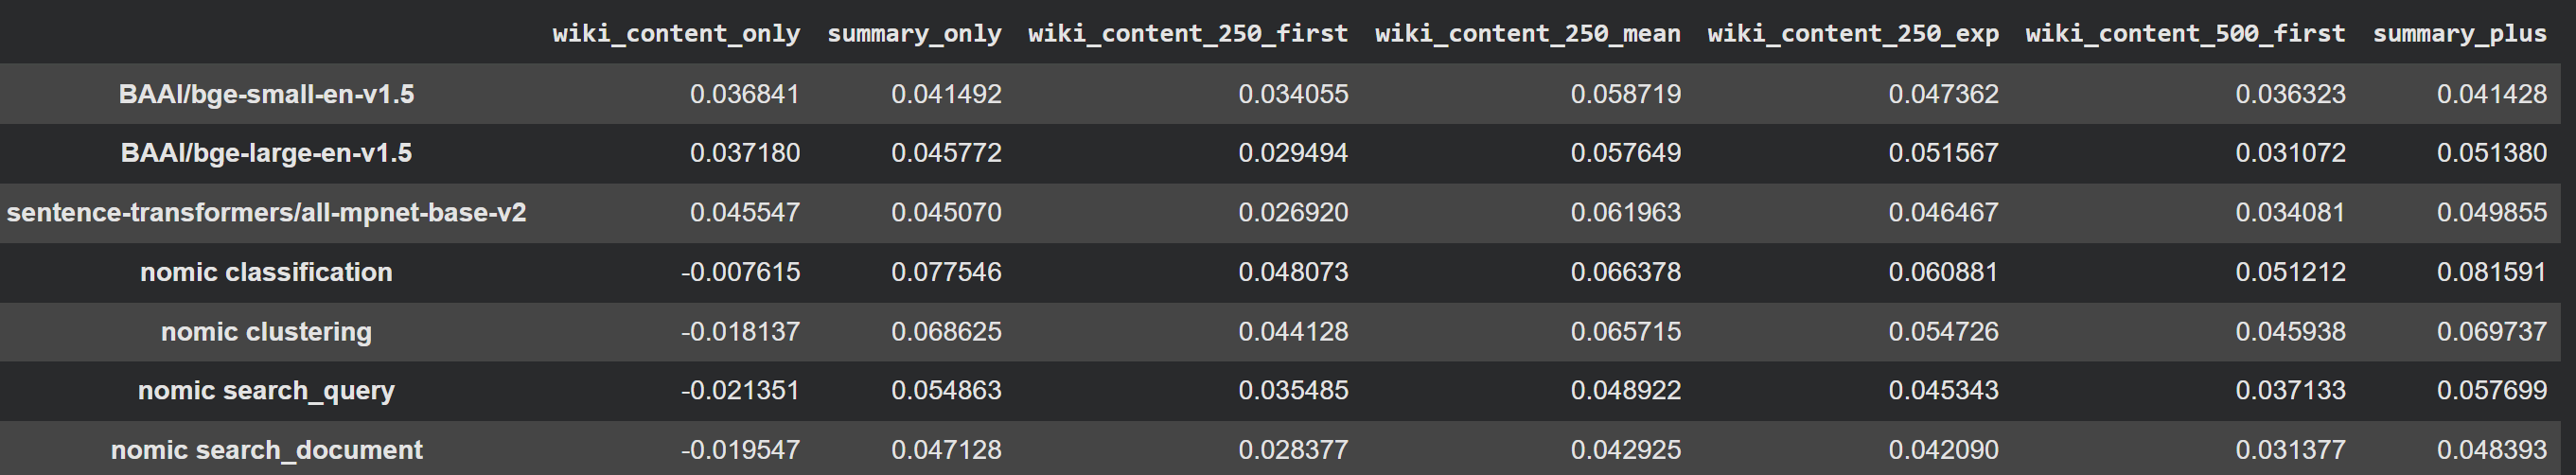

With this information, it is safe to delete the 250-first, and 250-exp, and 500-first as they are all marketly worse than the summary field. Which is what the code below would reflect that we did. However due to MongoDB not allowing for any more write commands and not being even able to edit documents directly, we had to spend money to upgrade to a Flex plan for this project. The code is left as an artifact to show what was learned on this project.

In [ ]:
print("Starting removal of specified embedding configurations...")
unset_list = [[250,'first'],[250,'exponential'],[500,'first'],[500,'exponential'],[1000,'first'],[1000,'mean']]
for item in unset_list:
    chunk_size_to_unset = item[0]
    aggregation_to_unset = item[1]

    for model_str in embeddings_lst:
        # Define the embedding configuration to be removed
        embedding_config_to_remove = {
            'model': model_str,
            'chunk_size': chunk_size_to_unset,
            'aggregation': aggregation_to_unset,
            'input': 'wiki_content_only' # Assuming this is consistent for all unsets
        }

        has_embedding_cursor = collection.find(
              {'embeddings': {'$elemMatch': embedding_config_to_remove}},
              {'_id': 1}
          )
        existing_ids = {doc['_id'] for doc in has_embedding_cursor}
        print(f"[INFO] {len(existing_ids)} docs need to be updated for model {model_str}, chunk size {chunk_size_to_unset}, aggregation {aggregation_to_unset}")

        # Use $pull to remove elements from the 'embeddings' array that match the config
        result = collection.update_many(
            {}, # Query all documents
            { '$pull': { 'embeddings': embedding_config_to_remove } }
        )

        print(f"Removed {result.modified_count} embeddings for model: {model_str}, chunk_size: {chunk_size_to_unset}, aggregation: {aggregation_to_unset}.")

print("Finished removal of specified embedding configurations.")

Starting removal of specified embedding configurations...
[INFO] 990 docs need to be updated for model BAAI/bge-small-en-v1.5, chunk size 250, aggregation first


OperationFailure: you are over your space quota, using 515 MB of 512 MB, full error: {'ok': 0, 'errmsg': 'you are over your space quota, using 515 MB of 512 MB', 'code': 8000, 'codeName': 'AtlasError'}